# Model Comparison: MobileNetV2 vs ResNet50V2 vs EfficientNetB0

This notebook trains and evaluates three pre-trained CNN architectures on the Rice Leaf dataset to identify the best performing model.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
import matplotlib.pyplot as plt
import numpy as np
import os
import json

# Configuration
BATCH_SIZE = 16
IMG_SIZE = (224, 224)
DATA_DIR = 'data/riceleaf'
EPOCHS = 5

print(f"Using TensorFlow Version: {tf.__version__}")

Using TensorFlow Version: 2.20.0


## 1. Data Loading and Preprocessing

In [2]:
print("Loading Data...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'train'),
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'val'),
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
print(f"Classes: {class_names}")

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Loading Data...
Found 12983 files belonging to 7 classes.
Found 1038 files belonging to 2 classes.
Classes: ['blast', 'healthy', 'insect', 'leaf_folder', 'scald', 'stripes', 'tungro']


## 2. Model Factory

In [3]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
])

def create_model(model_name):
    inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)
    
    if model_name == 'MobileNetV2':
        base_model = applications.MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
    elif model_name == 'ResNet50V2':
        base_model = applications.ResNet50V2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
    elif model_name == 'EfficientNetB0':
        base_model = applications.EfficientNetB0(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
    
    base_model.trainable = False # Transfer Learning
    
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(len(class_names), activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs, name=model_name)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [4]:
models_to_test = ['MobileNetV2', 'ResNet50V2', 'EfficientNetB0']
history_dict = {}
best_acc = 0
best_model_name = ""
best_model_obj = None

for name in models_to_test:
    print(f"\n{'='*20}\nTraining {name}...\n{'='*20}")
    try:
        model = create_model(name)
        history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)
        history_dict[name] = history.history['val_accuracy']
        
        val_acc = max(history.history['val_accuracy'])
        print(f"{name} Best Val Acc: {val_acc:.4f}")
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_name = name
            best_model_obj = model
    except Exception as e:
        print(f"Failed to train {name}: {e}")

print(f"\n{'='*20}\nWinner: {best_model_name} with Val Acc: {best_acc:.4f}\n{'='*20}")


Training MobileNetV2...
Epoch 1/5
812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.4342 - loss: 1.4919Failed to train MobileNetV2: Graph execution error:

Detected at node decode_image/DecodeImage defined at (most recent call last):
<stack traces unavailable>
jpeg::Uncompress failed. Invalid JPEG data or crop window.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]] [Op:__inference_multi_step_on_iterator_13887]

Training ResNet50V2...
Epoch 1/5
812/812 ━━━━━━━━━━━━━━━━━━━━ 622s 743ms/step - accuracy: 0.4683 - loss: 1.4065 - val_accuracy: 0.6260 - val_loss: 0.9537
Epoch 2/5


C:\Users\Jack Brayan\AppData\Roaming\Python\Python313\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


812/812 ━━━━━━━━━━━━━━━━━━━━ 562s 692ms/step - accuracy: 0.5314 - loss: 1.2449 - val_accuracy: 0.6377 - val_loss: 0.8380
Epoch 3/5
812/812 ━━━━━━━━━━━━━━━━━━━━ 428s 527ms/step - accuracy: 0.5437 - loss: 1.2189 - val_accuracy: 0.6211 - val_loss: 0.8754
Epoch 4/5
812/812 ━━━━━━━━━━━━━━━━━━━━ 487s 600ms/step - accuracy: 0.5526 - loss: 1.1921 - val_accuracy: 0.5293 - val_loss: 1.0059
Epoch 5/5
812/812 ━━━━━━━━━━━━━━━━━━━━ 506s 623ms/step - accuracy: 0.5529 - loss: 1.1800 - val_accuracy: 0.6289 - val_loss: 0.9211
ResNet50V2 Best Val Acc: 0.6377

Training EfficientNetB0...
Epoch 1/5
812/812 ━━━━━━━━━━━━━━━━━━━━ 574s 677ms/step - accuracy: 0.2633 - loss: 1.8039 - val_accuracy: 0.2568 - val_loss: 1.2730
Epoch 2/5
812/812 ━━━━━━━━━━━━━━━━━━━━ 264s 325ms/step - accuracy: 0.2618 - loss: 1.8023 - val_accuracy: 0.2568 - val_loss: 1.4054
Epoch 3/5
812/812 ━━━━━━━━━━━━━━━━━━━━ 284s 350ms/step - accuracy: 0.2653 - loss: 1.8043 - val_accuracy: 0.7432 - val_loss: 1.3877
Epoch 4/5
812/812 ━━━━━━━━━━━━━━━

Saved best_multimodel.keras


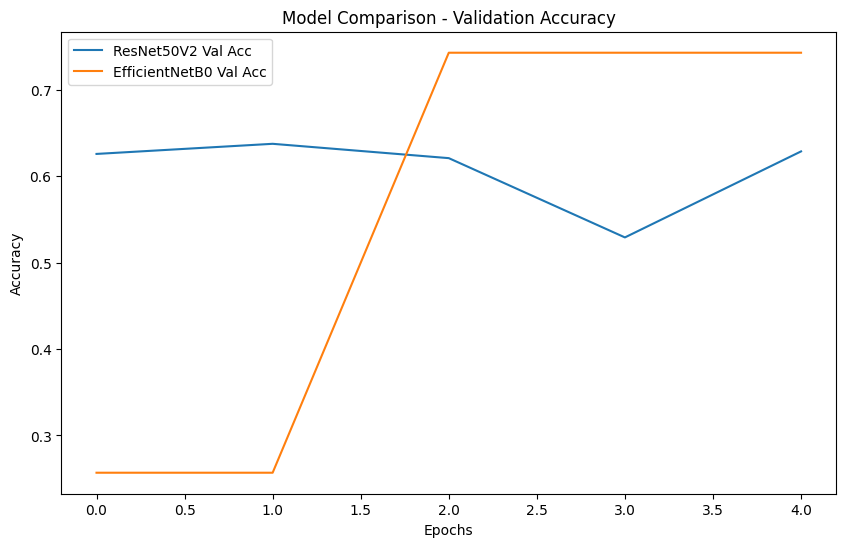

In [5]:
if best_model_obj:
    # Save Best Model
    best_model_obj.save('best_multimodel.keras')
    print("Saved best_multimodel.keras")
    
    # Save metadata for the app
    with open('best_model_info.json', 'w') as f:
        json.dump({
            "model_name": best_model_name, 
            "accuracy": best_acc,
            "class_names": class_names
        }, f)

# Comparison Plot
plt.figure(figsize=(10, 6))
for name, accs in history_dict.items():
    plt.plot(accs, label=f'{name} Val Acc')
plt.title('Model Comparison - Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()